In [1]:
import os
import google.generativeai as genai

genai.configure(api_key='YOUR_API_KEY')

In [2]:
import time
import io
import base64
from PIL import Image
from pynput.keyboard import Controller
import pyautogui
import numpy as np
import typing_extensions as typing
import os
import subprocess
import time
import json
import math

In [3]:
def get_window_geometry(window_title):
    try:
        # `wmctrl`でウィンドウリストを取得
        wmctrl_output = subprocess.check_output(['wmctrl', '-l']).decode('utf-8')
        target_line = None

        for line in wmctrl_output.splitlines():
            if window_title in line:
                target_line = line
                break

        if not target_line:
            raise ValueError(f"Window with title '{window_title}' not found.")

        # ウィンドウIDを取得
        window_id = target_line.split()[0]
        
        # `xwininfo`でウィンドウの座標を取得
        xwininfo_output = subprocess.check_output(['xwininfo', '-id', window_id]).decode('utf-8')
        coords = {}
        for line in xwininfo_output.splitlines():
            if "Absolute upper-left X" in line:
                coords['x'] = int(line.split(':')[-1].strip())
            elif "Absolute upper-left Y" in line:
                coords['y'] = int(line.split(':')[-1].strip())
            elif "Width" in line:
                coords['width'] = int(line.split(':')[-1].strip())
            elif "Height" in line:
                coords['height'] = int(line.split(':')[-1].strip())

        if not coords:
            raise ValueError("Failed to get window coordinates.")

        return coords

    except Exception as e:
        raise RuntimeError(f"Failed to get window geometry: {e}")

def capture_window(window_title, output_path="screenshot.png", use_imagemagick=False):
    try:
        # ウィンドウの位置とサイズを取得
        geometry = get_window_geometry(window_title)

        if use_imagemagick:
            # ImageMagick (`import` コマンド) を使用してスクリーンショットを取得
            window_id = subprocess.check_output(
                ['wmctrl', '-l', '-x'], text=True
            ).splitlines()
            cmd = [
                'import', '-window', window_id,
                '-crop', f"{geometry['width']}x{geometry['height']}+{geometry['x']}+{geometry['y']}",
                output_path
            ]
            subprocess.run(cmd, check=True)
            return Image.open(output_path)
        else:
            # PyAutoGUIでスクリーンショットを取得
            screenshot = pyautogui.screenshot(region=(
                geometry['x'],
                geometry['y'],
                geometry['width'],
                geometry['height']
            ))
            screenshot.save(output_path)
            return screenshot

    except Exception as e:
        raise RuntimeError(f"Failed to capture window: {e}")

In [4]:
def preprocess_image(image):
    # クロップとリサイズ
    pil_image = image.copy()
    pil_image = pil_image.crop((0, pil_image.height // 2 - 200, pil_image.width, pil_image.height // 2 + 200))
    pil_image = pil_image.resize((pil_image.width // 4, pil_image.height // 4))
    display(pil_image)
    # 変換
    buffered = io.BytesIO()
    pil_image.save(buffered, format="PNG")
    image_str = base64.b64encode(buffered.getvalue()).decode()
    return pil_image, image_str

def send_to_gemini(img):
    # prompt = f"""
    # 与えられた画像に基づいて、コースを逸脱しないようにカートを運転するためのアクションを選択してください。
    # 選択肢は以下です。
    
    #  - “↑”: 加速
    #  - “↓”: 減速
    #  - “←”: 左へ操舵
    #  - “→”: 右へ操舵
    #  """
    prompt = f"""
    Based on the given image, choose an action to drive the cart so that it does not deviate from the course.
    The choices are as follows
    
    - “↑”: Accelerate
    - “↓”: Decelerate
    - "←": Steer left
    - "→": Steer right
    """
    start = time.perf_counter() 
    response = model.generate_content(
        [prompt, img],
        generation_config=genai.GenerationConfig(
            response_mime_type="application/json",
            response_schema=ControlCommand
        ),
    )
    end = time.perf_counter()
    latency = end-start
    print(f"Latency: {latency}")
    return response, latency

def execute_action(response):
    probability = math.exp(response.to_dict()["candidates"][0]["avg_logprobs"])
    response = json.loads(response.text.strip())
    command = response["command"]
    reason = response["reason"]
    print(f"Executing Command: {command}, Reason: {reason}, Probability: {probability}")
    print()
    
    base_duration = 0.1
    increase_duration = 0.2
    thresh_duration = 1.0
    duration = base_duration
    
    global right_counter, left_counter
    if command == "→":
        right_counter += 1
        duration = base_duration + (right_counter * increase_duration)
        print(f"Right counter: {right_counter}, Increased duration: {duration}")
    elif command == "←":
        left_counter += 1
        duration = base_duration + (left_counter * increase_duration)
        print(f"Left counter: {left_counter}, Increased duration: {duration}")
    else:
        right_counter = 0
        left_counter = 0
        duration = base_duration
    
    if duration > thresh_duration:
        if command == "←":
            keyboard.press('a')
        elif command == "→":
            keyboard.press('d')
        elif command == "↑":
            keyboard.press('w')
        elif command == "↓":
            keyboard.press('s')
    else:
        if command == "←":
            keyboard.press('a')
            time.sleep(duration)
            keyboard.release('a')
        elif command == "→":
            keyboard.press('d')
            time.sleep(duration)
            keyboard.release('d')
        elif command == "↑":
            keyboard.press('w')
        elif command == "↓":
            keyboard.press('s')
        else:
            print("No valid command received or command is none.")

In [5]:
class ControlCommand(typing.TypedDict):
    command: str
    reason: str

# モデルの初期化
model = genai.GenerativeModel("gemini-1.5-flash")

# キーボードコントローラー
keyboard = Controller()

# カウンターの初期化
right_counter = 0
left_counter = 0

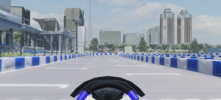

Latency: 1.5366061280074064
Executing Command: ↑, Reason: The image shows a straight track; therefore, the cart should accelerate to maintain its course., Probability: 0.8459894578741339



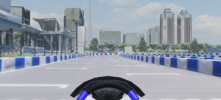

Latency: 1.299517804000061
Executing Command: ↑, Reason: The cart is going straight on the track, so we should accelerate to maintain its speed and trajectory., Probability: 0.7441290464713998



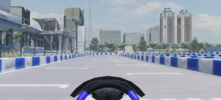

Latency: 1.1666602670156863
Executing Command: ↑, Reason: The image shows a straight track ahead; therefore, acceleration is needed to maintain the cart's course., Probability: 0.885847739146739



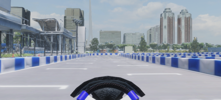

Latency: 1.1382638280047104
Executing Command: ↑, Reason: The cart is going straight, and there is no need to steer. Therefore, only acceleration is needed to proceed., Probability: 0.7381557779471069



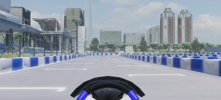

Latency: 1.3001879770017695
Executing Command: ↑, Reason: The image shows a straight track, so no steering is needed.  The cart should accelerate to maintain speed and progress., Probability: 0.8003285027523548



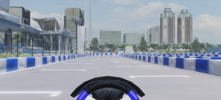

Latency: 1.0958041760022752
Executing Command: ↑, Reason: The image shows a straight track ahead; therefore, acceleration is needed to maintain the course., Probability: 0.9458842078171218



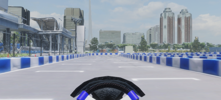

Latency: 1.20419003101415
Executing Command: ↑, Reason: The cart is moving straight, so we need to accelerate to maintain the speed and stay on course., Probability: 0.6872370984838687



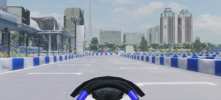

Latency: 1.090188524016412
Executing Command: ↑, Reason: The cart is going straight and needs to maintain its speed to stay on course., Probability: 0.9024355235555009



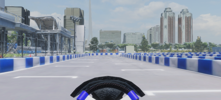

Latency: 1.0285863610042725
Executing Command: ↑, Reason: The cart is going straight and needs to maintain its speed to stay on course., Probability: 0.9032559328014415



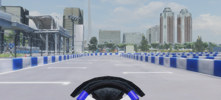

Latency: 1.3604042170045432
Executing Command: ↑, Reason: The image shows a straight track; therefore, to proceed on the course, the cart must accelerate., Probability: 0.7616017136591519



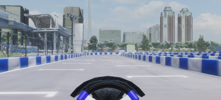

Latency: 1.104183641000418
Executing Command: ↑, Reason: The image shows a straight track ahead, so accelerating is the appropriate action to maintain the course., Probability: 0.8739932108796334



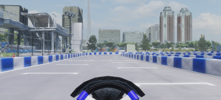

Latency: 1.015358542004833
Executing Command: ↑, Reason: The cart is going straight; therefore, it needs to accelerate to maintain its position on the course., Probability: 0.7122895518321953



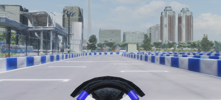

Latency: 1.0044371169933584
Executing Command: ↑, Reason: The cart is in the center of the track, so it needs to accelerate to maintain its position., Probability: 0.7807580115734617



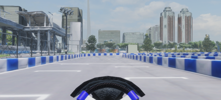

Latency: 1.015676776994951
Executing Command: ↑, Reason: The image shows a straight track ahead; therefore, acceleration is needed to maintain the course., Probability: 0.9473062660246087



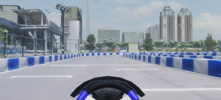

Latency: 1.153714274027152
Executing Command: ↑, Reason: The image shows a straight track ahead; therefore, acceleration is needed to proceed., Probability: 0.8627744292657256



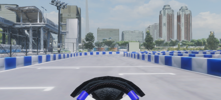

Latency: 1.0805771839804947
Executing Command: ↑, Reason: The cart is in the center of the lane and there is no need to steer.  It should accelerate to maintain its position., Probability: 0.7447729260199931



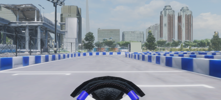

Latency: 1.0743571580096614
Executing Command: ↑, Reason: The image shows a straight track; therefore, acceleration is needed to move forward without deviating from the course., Probability: 0.8672024567203347



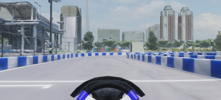

Latency: 1.0492879840021487
Executing Command: ↑, Reason: The image shows a straight track ahead; therefore, acceleration is needed to move forward without deviating., Probability: 0.8922003991874734



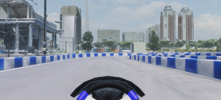

Latency: 1.1896526589989662
Executing Command: ↑, Reason: The cart is going straight and there is no need to steer. Accelerating will help maintain speed and keep the cart on course., Probability: 0.8008083193394271



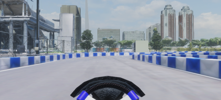

Latency: 1.1465630080201663
Executing Command: →, Reason: The cart is slightly deviating to the left. Steering to the right will correct this deviation., Probability: 0.8577177366406341

Right counter: 1, Increased duration: 0.30000000000000004


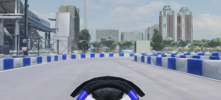

Latency: 1.0374218510114588
Executing Command: ↑, Reason: The cart is going straight, so accelerating is the only needed action., Probability: 0.7177792227245757



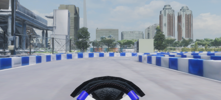

Latency: 1.0211925019975752
Executing Command: ↑, Reason: The cart is moving straight, and there is no need to steer. Acceleration is needed to keep the cart on the course., Probability: 0.6994271850470309



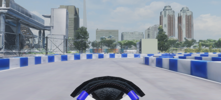

Latency: 1.017371527996147
Executing Command: →, Reason: The image shows that the cart is approaching a right turn.  Steering right will keep the cart on the course., Probability: 0.8416434186803431

Right counter: 1, Increased duration: 0.30000000000000004


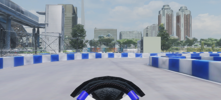

Latency: 1.099000732996501
Executing Command: ↑, Reason: The cart is moving towards the turn. Acceleration will help it maintain speed and momentum through the turn., Probability: 0.5325060069428864



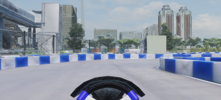

Latency: 1.0636900340032298
Executing Command: →, Reason: The cart is approaching a right turn. Steering right will help it to navigate the turn without deviating from the course., Probability: 0.8609491715634024

Right counter: 1, Increased duration: 0.30000000000000004


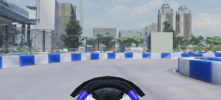

Latency: 1.0166633180051576
Executing Command: →, Reason: The cart is approaching a right turn. Steering right will keep the cart on the track., Probability: 0.8752469240604407

Right counter: 2, Increased duration: 0.5


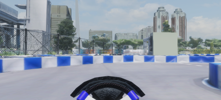

Latency: 1.0463910850230604
Executing Command: →, Reason: The cart is approaching a right turn. Steering right will help it follow the curve of the track., Probability: 0.8079642967169981

Right counter: 3, Increased duration: 0.7000000000000001


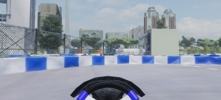

Latency: 1.097899693006184
Executing Command: →, Reason: The image shows the cart approaching a right turn. To stay on course, it needs to steer right., Probability: 0.9250730418184894

Right counter: 4, Increased duration: 0.9


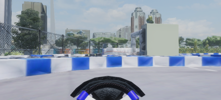

Latency: 1.1915743190038484
Executing Command: →, Reason: The image shows the cart is slightly deviating to the left. Steering to the right will correct the course., Probability: 0.9025996970597934

Right counter: 5, Increased duration: 1.1


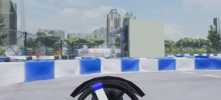

Latency: 0.9912718900013715
Executing Command: →, Reason: The cart is veering slightly to the left. A slight steer to the right will correct the course., Probability: 0.8116680553590351

Right counter: 6, Increased duration: 1.3000000000000003


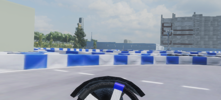

Latency: 1.0620934439939447
Executing Command: →, Reason: The cart is slightly deviating to the left. Steering to the right will correct the course., Probability: 0.9192799415118248

Right counter: 7, Increased duration: 1.5000000000000002


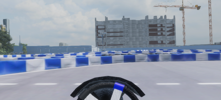

Latency: 1.0045675830042455
Executing Command: ↑, Reason: The image shows a straight track ahead; therefore, acceleration is needed to maintain the course., Probability: 0.9026531110053948



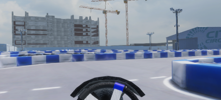

Latency: 1.0860250499972608
Executing Command: →, Reason: The cart is slightly deviating to the left, therefore steering to the right will keep it on course., Probability: 0.8677819305952124

Right counter: 1, Increased duration: 0.30000000000000004


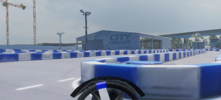

Latency: 1.0476875000167638
Executing Command: ↑, Reason: The cart is currently at rest. To proceed along the track, acceleration is necessary., Probability: 0.6477058787157464



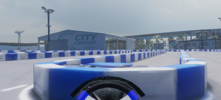

Latency: 1.0913929179951083
Executing Command: →, Reason: The cart is approaching a right turn. Steering right will help it follow the course., Probability: 0.8295193368563434

Right counter: 1, Increased duration: 0.30000000000000004


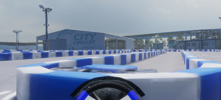

Latency: 1.0628697679785546
Executing Command: ↑, Reason: The cart is already on the track, and to keep moving forward, we need to accelerate., Probability: 0.6596277720791077



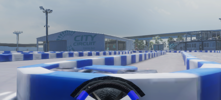

Latency: 1.1363305999839213
Executing Command: ↑, Reason: The cart is currently not moving and needs to accelerate to proceed on the course., Probability: 0.8418693496787532



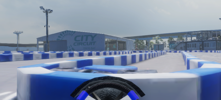

Latency: 1.036978269024985
Executing Command: ↑, Reason: The cart is going straight and needs to accelerate to maintain its course., Probability: 0.8102694506180524



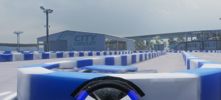

Latency: 1.3364596089813858
Executing Command: ↑, Reason: The cart is already in the center of the track and there is no need to steer.  The image shows a straight section of track ahead, therefore, accelerating is the appropriate action., Probability: 0.6583200696014773



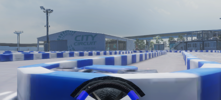

Latency: 1.3627533669932745
Executing Command: ↑, Reason: The cart is already on the track and needs to accelerate to continue on the course., Probability: 0.7593620083697911



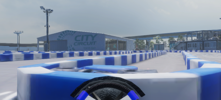

Latency: 1.0374484949861653
Executing Command: ↑, Reason: The cart is in a straight section of the track, so accelerating is the appropriate action., Probability: 0.8123334349798129



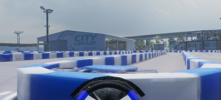

Latency: 1.0061549490201287
Executing Command: ↑, Reason: The cart is currently at a low speed and needs to accelerate to maintain its course., Probability: 0.8555862319458223



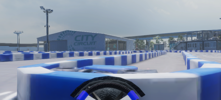

Latency: 1.0433981149981264
Executing Command: ↑, Reason: The cart is going straight on the track; therefore, it needs to accelerate to maintain its speed., Probability: 0.7619190644478641



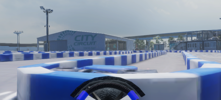

Latency: 1.307205134013202
Executing Command: ↑, Reason: The cart is currently at a low speed and needs acceleration to stay on course., Probability: 0.6807434264065124



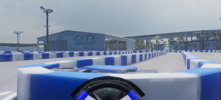

Latency: 1.1271977740107104
Executing Command: ↑, Reason: The cart is in a straight section of the track, so accelerating will keep it on course., Probability: 0.8062353834219613

Error in loop: Failed to capture window: Failed to get window geometry: Window with title 'AWSIM' not found.


In [6]:
while True:
    try:
        # 1. シミュレータの画面をキャプチャ
        frame = capture_window("AWSIM", use_imagemagick=False)
        
        # 2. キャプチャ画像を前処理して文字列化
        img, img_str = preprocess_image(frame)
        
        # 3. 画像をGeminiに送信して制御コマンドを取得
        action_response, latency = send_to_gemini(img)
        
        # 4. コマンドに基づきシミュレータを操作
        execute_action(action_response)
        
        # 5. 15RPMに調整
        if( 4.0 - latency > 0):
            time.sleep(4.0-latency)
        
    except Exception as e:
        print(f"Error in loop: {e}")
        break
